"""
    This code accepts two input: an image you wish to extract tiles from and a complementary binary raster (annotation file)
    It will: 
        Divide the image to train,test,val datasets
        Extract tiles from image and add padding (if desired)
        Extract tiles from annotation file and compute sum of 1s for each
        Move image tiles to folders labelled with corresponding sum
        Rename image tiles to include sum as filename prefix
    
    Parameters
        ----------
        img_path : file path to .tif file
            Location of image to be tiled (ideally 3-band, RGB)
            Image must be 10cm spatial resolution if you plan to use tiles with Tree-CRowNN model
        mask_path : file path
            Location of annotation mask .tif file
            Annotation mask must be binary where 1 = target and 0 = non-target
            Must be georeferenced to, and match spatial resolution of, img_path file  
        NoData : int or float
            Value representing NoData in img_path file 
        out_path : folder path where data will be written
  
        
        target : float
            Value identifying data split (train, test, val)
            E.G. A value of 0.2 represents a split (percentage) of 60/20/20
        patch_size : int
            Value identifying the desired dimensions of extracted tiles
            Enter value of -1 to randomly generate patch_size between 64-128pix
        padding : int
            Value identifying the desired amount of zero padding to be added to tiles
            Enter value of -1 to use random integer generator (0-32)
            If planning to use tiles with Tree-CRowNN Model:
                Use padding to reach tile size of 128 if patch_size < 128
                E.G. A padding value of 14 should be used when patch_size = 100 to create tiles of dimension 128p X 128p
        
        Returns
        -------
        Image tiles saved as 3-band .png files
        
        Tiles are:
            Split into train, test, and validation datasets 
            Organized in folders labelled with tree counts
            Naming convention = treecount_y_x_plotsize.png 
                where: 
                    y = row and x = col location in img_path file
                    plotsize = ground dimensions represented in data of tile (assuming input image resolution of 10cm)
        
        THE CODE INCLUDES FILTERS TO AVOID NODATA (ALL 0, ALL -9999) AND INCOMPLETE/NON-SQUARE TILES
        A THOROUGH QA/QC OF GENERATED TILES SHOULD BE COMPLETED PRIOR TO USING FOR MODEL DEV
"""

In [2]:
#set up
import os, sys, PIL, ntpath, cv2, ipynb.fs, session_info, time,random
from PIL import Image
import pandas as pd
import numpy as np
from numpy import inf
import tifffile as tiff
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [3]:
#import preprocessing functions
from ipynb.fs.full.TreeCRowNNv2_Functions_1 import *
session_info.show()

## Set Params

In [44]:
#img_path = 'C:/Users/jlovitt/Pyworking/TreeCRowNN_Transfer/UofC/StonyFen_10cm.tif'
#mask_path = 'C:/Users/jlovitt/Pyworking/TreeCRowNN_Transfer/UofC/StonyFen_treepts_binary.tif'
#img_path = 'F:/MtPolley/tree_counting/10cm_Resamples/2021_SumacSouthON_10cm/n9_10cm.tif'
#mask_path = 'F:/MtPolley/tree_counting/10cm_Resamples/Elisha_tree_counts/N9_tree_count/raster/n9_notrees_binary.tif'

img_path = 'F:/MtPolley/tree_counting/10cm_Resamples/2022_UofC/StonyWest_10cm_clip.tif'
mask_path = 'F:/MtPolley/tree_counting/10cm_Resamples/Elisha_tree_counts/StonyWest_tree_count_JL/StonyWest_notrees_binary_clip.tif'

#img_path = 'D:/Pyworking/for_CNN_5/2019_ortc1.tif'
#mask_path = 'D:Pyworking/for_CNN_5/RGB_aerial/tc_reg_ortho.tif'
#img_path = "E:/MtPolley_Project/4_GIS/for_CNN/2022_additional_data_for_trainingCNN/2019OC1.tif"
#mask_path = "E:/MtPolley_Project/4_GIS/for_CNN/2022_additional_data_for_trainingCNN/2019NTC1.tif"

#img_path = "E:/MtPolley_Project/4_GIS/for_CNN/ortho/2023_treecounting/2019_ortho/additional_area/add_ort2019.tif"
#mask_path = "E:/MtPolley_Project/4_GIS/for_CNN/ortho/2023_treecounting/2019_ortho/additional_area/add_tc2019.tif"

NoData = -9999

out_path = r'C:/Users/jlovitt/Pyworking/TreeCRowNN_Transfer/ALL/notrees/'

target = 0.2
padding = -1 #enter -1 for random
patch_size = -1  #enter -1 for random

## Import Data

In [45]:
large_image_stack = tiff.imread(img_path)
large_image_stack[large_image_stack==NoData] = -9999
large_mask_file = tiff.imread(mask_path).astype(np.uint16)

print("MULTI-CHANNEL IMAGE SHAPE : ",large_image_stack.shape, " MIN ",np.min(large_image_stack)," MAX ", np.max(large_image_stack))
print("ANNOTATION FILE SHAPE : ",large_mask_file.shape," MIN ",np.min(large_mask_file)," MAX ",np.max(large_mask_file))

MULTI-CHANNEL IMAGE SHAPE :  (12593, 11689, 4)  MIN  0.0  MAX  255.0
ANNOTATION FILE SHAPE :  (12593, 11689)  MIN  0  MAX  1


## Split Data

In [46]:
make_folders(out_path)

In [47]:
tc_chan = 0
x,y = large_mask_file.shape
cropx = get_crop_dims(x,patch_size)
cropy = get_crop_dims(y,patch_size)
print("crop_x: ",cropx,"crop_y: ",cropy)
step_size = patch_size//2

crop_x:  12593 crop_y:  11689


In [48]:
#RGB image prep
train_stk, test_stk, val_stk, time1 = split_dataset(large_image_stack,target,cropx,cropy)
#large_mask_file[large_mask_file==55537] = 0
tc_c = crop_center(large_mask_file,cropx,cropy)
tc_train = crop_trainset(tc_c,target)
tc_test=crop_testset(tc_c,target)
tc_val=crop_valset(tc_c,target)
tc_c = None
del(tc_c)

0 12593 0 11689
(11689, 11689)
0 11689 4675 11689
0 11689 0 2337
0 11689 2337 4675
0 12593 0 11689
(11689, 11689)
0 11689 4675 11689
0 11689 0 2337
0 11689 2337 4675
0 12593 0 11689
(11689, 11689)
0 11689 4675 11689
0 11689 0 2337
0 11689 2337 4675
0 12593 0 11689
(11689, 11689)
0 11689 4675 11689
0 11689 0 2337
0 11689 2337 4675
0 12593 0 11689
(11689, 11689)
0 11689 4675 11689
0 11689 0 2337
0 11689 2337 4675


In [49]:
print("TRAINING SET   (y,x)   ==>   RGB:",train_stk.shape,", Tree Count:",tc_train.shape)
print("TESTING SET    (y,x)   ==>   RGB:",test_stk.shape,", Tree Count:",tc_test.shape)
print("VALIDATION SET (y,x)   ==>   RGB:",val_stk.shape,", Tree Count:",tc_val.shape)

TRAINING SET   (y,x)   ==>   RGB: (7014, 11689, 3) , Tree Count: (7014, 11689)
TESTING SET    (y,x)   ==>   RGB: (2337, 11689, 3) , Tree Count: (2337, 11689)
VALIDATION SET (y,x)   ==>   RGB: (2338, 11689, 3) , Tree Count: (2338, 11689)


## Process Training Dataset

In [50]:
ymax, xmax, chan = train_stk.shape

out1 = out_path+"train/"
out2 = out1+"organized/"

tree_pts = get_pts(tc_train)
print("TOTAL ANNOTATIONS FOUND : ",len(tree_pts))

TOTAL ANNOTATIONS FOUND :  9


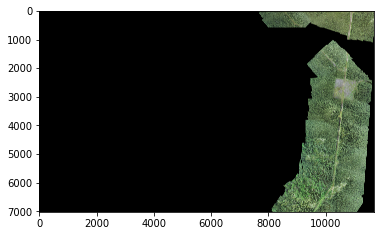

In [51]:
plt.imshow(train_stk//255)

In [52]:
patch_list,t3 = make_tiles(out1,out2,tree_pts,train_stk,tc_train,xmax,ymax,patch_size,padding)
train_tiles = len(patch_list)
print(train_tiles," TRAINING TILES GENERATED AND ORGANIZED IN : ",round(t3,5), " SECONDS")
print("TOTAL PROCESSING TIME PER TILE : ",round(t3/train_tiles,5), " SECONDS")

9  TRAINING TILES GENERATED AND ORGANIZED IN :  0.044  SECONDS
TOTAL PROCESSING TIME PER TILE :  0.00489  SECONDS


## Process Test Dataset

In [53]:
ymax, xmax, chan = test_stk.shape

out1 = out_path+"test/"
out2 = out1+"organized/"

tree_pts = get_pts(tc_test)
print("TOTAL ANNOTATIONS FOUND : ",len(tree_pts))

TOTAL ANNOTATIONS FOUND :  6


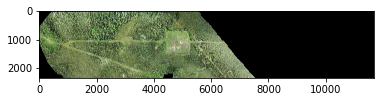

In [54]:
plt.imshow(test_stk//255)

In [55]:
patch_list,t5 = make_tiles(out1,out2,tree_pts,test_stk,tc_test,xmax,ymax,patch_size,padding)
test_tiles = len(patch_list)
print(test_tiles," TESTING TILES GENERATED AND ORGANIZED IN : ",round(t5,5), " SECONDS")
print("TOTAL PROCESSING TIME PER TILE : ",round(t5/test_tiles,5), " SECONDS")

6  TESTING TILES GENERATED AND ORGANIZED IN :  0.027  SECONDS
TOTAL PROCESSING TIME PER TILE :  0.0045  SECONDS


## Process Validation Dataset

In [56]:
ymax, xmax, chan = val_stk.shape

out1 = out_path+"val/"
out2 = out1+"organized/"

tree_pts = get_pts(tc_val)
print("TOTAL ANNOTATIONS FOUND : ",len(tree_pts))

TOTAL ANNOTATIONS FOUND :  1


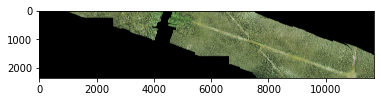

In [57]:
plt.imshow(val_stk//255)

In [58]:
patch_list,t7 = make_tiles(out1,out2,tree_pts,val_stk,tc_val,xmax,ymax,patch_size,padding)
val_tiles = len(patch_list)
print(val_tiles," VALIDATION TILES GENERATED AND ORGANIZED IN : ",round(t7,5), " SECONDS")
print("TOTAL PROCESSING TIME PER TILE : ",round(t7/val_tiles,5), " SECONDS")

1  VALIDATION TILES GENERATED AND ORGANIZED IN :  0.01005  SECONDS
TOTAL PROCESSING TIME PER TILE :  0.01005  SECONDS


## Total Processing Time

In [23]:
print("TOTAL TRAIN TILES : ",train_tiles, " TOTAL TEST TILES : ", test_tiles," TOTAL VALIDATION TILES : ", val_tiles)
print((train_tiles+test_tiles+val_tiles)," TILES GENERATED ")#IN : ",round((t1+t2+t3+t4+t5+t6+t7)/60,2), " MINUTES")

TOTAL TRAIN TILES :  269  TOTAL TEST TILES :  40  TOTAL VALIDATION TILES :  27
336  TILES GENERATED 
